## NHL Season Outcome Multiple Linear Regression

### Description

The following regression analysis seeks to predict team season adjusted wins **(wins + (ties / 2))** above the season mean adjusted wins for years 1983 - 2020.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from regressors import stats as stat
from pickle import dump
from pickle import load

from scipy.stats.mstats import normaltest

from ipynb.fs.full.Preprocessing_Functions import *
from ipynb.fs.full.Regression_Metrics_Functions import *

### Feature Selection and Data Preprocessing

In [2]:
# Import the data frame from the multiple regression EDA
local_driectory = 'Data/NHL_1983_2020_Perprocessed_Data_Removed_Outliers.csv'
GitHub_link = 'https://raw.githubusercontent.com/joseppbenvenuto/NHL_Regression_Classification_Analysis/master/Regression_Analysis/Data/NHL_1983_2020_Perprocessed_Season_Data_Removed_Outliers.csv'
nhl_df = pd.read_csv(GitHub_link)
nhl_df = nhl_df.drop(['Unnamed: 0'], axis = 1, errors = 'ignore')


print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   goalsPerGame                 887 non-null    float64
 1   goalsAgainstPerGame          887 non-null    float64
 2   powerPlayPercentage          887 non-null    float64
 3   penaltyKillPercentage        887 non-null    float64
 4   shotsPerGame                 887 non-null    float64
 5   shotsAllowed                 887 non-null    float64
 6   shootingPctg                 887 non-null    float64
 7   savePctg                     887 non-null    float64
 8   savesPerGame                 887 non-null    float64
 9   failedShotsPerGame           887 non-null    float64
 10  ties                         887 non-null    int64  
 11  winScoreFirstGreater61_high  887 non-null    int64  
 12  aboveMeanAdjWins             887 non-null    float64
dtypes: float64(11), in

,goalsPerGame,goalsAgainstPerGame,powerPlayPercentage,penaltyKillPercentage,shotsPerGame,shotsAllowed,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,ties,winScoreFirstGreater61_high,aboveMeanAdjWins
0,2.888,4.375,14.3,75.3,26.3875,32.0000,10.9,86.3,27.616000,23.511263,7,0,-19.470588
1,4.463,3.363,22.5,81.5,30.2750,33.3875,14.7,89.9,30.015362,25.824575,4,1,12.029412
2,3.925,3.800,25.1,78.1,31.8875,31.5500,12.3,88.0,27.764000,27.965338,9,1,6.529412
3,4.375,3.625,20.2,76.6,36.7500,28.6500,11.9,87.3,25.011450,32.376750,10,1,9.029412
4,3.175,4.875,20.9,76.0,28.3375,36.3500,11.2,86.6,31.479100,25.163700,6,0,-20.970588


The data from the regression EDA analysis is imported.

In [3]:
# Create a y and X data frames
y = nhl_df[nhl_df.columns[len(nhl_df.columns)-1:]].reset_index(drop = True)
X = nhl_df[nhl_df.columns[0:len(nhl_df.columns)-1]].reset_index(drop = True)

# Split y and X data frames into an 80/20 train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Concatenate X and y data for both train and test data
train_set_df = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
test_set_df = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

print('\n','------------------------------------ Train Data ------------------------------------'.center(110),'\n')
print(train_set_df.info())
display(train_set_df.head())
print('\n','------------------------------------ Test Data ------------------------------------'.center(110),'\n')
print(test_set_df.info())
display(test_set_df.head())


              ------------------------------------ Train Data ------------------------------------              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   goalsPerGame                 709 non-null    float64
 1   goalsAgainstPerGame          709 non-null    float64
 2   powerPlayPercentage          709 non-null    float64
 3   penaltyKillPercentage        709 non-null    float64
 4   shotsPerGame                 709 non-null    float64
 5   shotsAllowed                 709 non-null    float64
 6   shootingPctg                 709 non-null    float64
 7   savePctg                     709 non-null    float64
 8   savesPerGame                 709 non-null    float64
 9   failedShotsPerGame           709 non-null    float64
 10  ties                         709 non-null    int64  
 11  winScoreFirstGreater6

,goalsPerGame,goalsAgainstPerGame,powerPlayPercentage,penaltyKillPercentage,shotsPerGame,shotsAllowed,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,ties,winScoreFirstGreater61_high,aboveMeanAdjWins
0,2.768,3.024,21.7,80.2,28.8537,33.4390,9.6,91.0,30.429490,26.083745,5,1,-1.600000
1,2.610,2.317,20.7,86.6,25.7317,25.0122,10.1,90.7,22.686065,23.132798,15,1,4.071429
2,4.225,4.213,22.2,76.0,29.6500,31.0375,14.2,86.4,26.816400,25.439700,7,1,-3.764706
3,2.439,2.146,15.1,84.7,27.4146,25.4878,8.9,91.6,23.346825,24.974701,10,1,3.089286
4,2.878,2.049,18.8,86.5,27.6341,23.9634,10.4,91.5,21.926511,24.760154,12,1,16.153846



              ------------------------------------ Test Data ------------------------------------               

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   goalsPerGame                 178 non-null    float64
 1   goalsAgainstPerGame          178 non-null    float64
 2   powerPlayPercentage          178 non-null    float64
 3   penaltyKillPercentage        178 non-null    float64
 4   shotsPerGame                 178 non-null    float64
 5   shotsAllowed                 178 non-null    float64
 6   shootingPctg                 178 non-null    float64
 7   savePctg                     178 non-null    float64
 8   savesPerGame                 178 non-null    float64
 9   failedShotsPerGame           178 non-null    float64
 10  ties                         178 non-null    int64  
 11  winScoreFirstGreater6

,goalsPerGame,goalsAgainstPerGame,powerPlayPercentage,penaltyKillPercentage,shotsPerGame,shotsAllowed,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,ties,winScoreFirstGreater61_high,aboveMeanAdjWins
0,2.561,2.463,11.0,85.3,26.1220,29.2561,9.8,91.6,26.798588,23.562044,18,1,2.153846
1,2.549,2.451,17.2,85.1,28.4146,30.9878,9.0,92.1,28.539764,25.857286,8,1,3.827586
2,2.415,3.341,16.9,79.8,28.9268,33.5488,8.3,90.0,30.193920,26.525876,9,0,-15.696429
3,2.415,3.134,15.5,76.6,29.9268,30.9390,8.1,89.9,27.814161,27.502729,7,0,-13.413793
4,3.171,2.427,17.2,83.5,32.3537,29.7683,9.8,91.8,27.327299,29.183037,4,1,5.086207


To prevent over-fitting, the data is split into an 80/20 train and test split and feature selection will take place and be determined by the train set and then applied to the test set. <br>

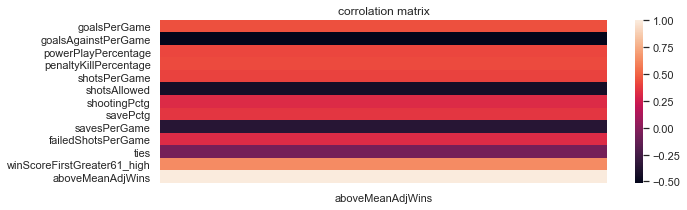

,aboveMeanAdjWins
aboveMeanAdjWins,1.000000
winScoreFirstGreater61_high,0.637429
goalsPerGame,0.445210
penaltyKillPercentage,0.426803
powerPlayPercentage,0.413948
shotsPerGame,0.401789
savePctg,0.362788
failedShotsPerGame,0.322762
shootingPctg,0.321709
ties,-0.066144



features to remove: 
['ties']


In [4]:
# Analyze correlation of all X features with target variables (aboveMeanAdjWins) on train data
X_num = train_set_df.select_dtypes(include = ['float64', 'int64'])
num_bivariate_corr_target(df = X_num, target = 'aboveMeanAdjWins', threshold = 0.20, font = 1, length = 3, width = 10)

In [5]:
# Remove ties feature from both train and test data
train_set_df = train_set_df.drop(['ties'], axis =1)
test_set_df = test_set_df.drop(['ties'], axis =1)

The ties feature is removed from train and test data because it lacks a strong corrolation defined by a threshold of at least 0.20 with aboveMeanAdjWins.

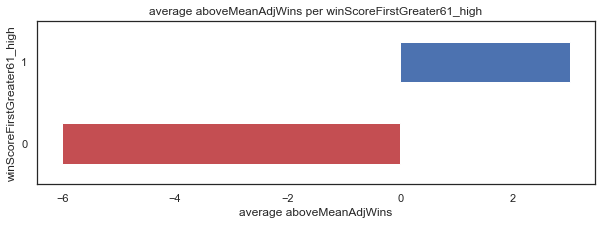

,aboveMeanAdjWins,positive
winScoreFirstGreater61_high,,
1,3.0,True
0,-6.0,False


In [6]:
# Observe the average aboveMeanAdjWins per winScoreFirstGreater61 outcomes
cat_col = train_set_df.copy()
cat_col = cat_col[['winScoreFirstGreater61_high', 'aboveMeanAdjWins']]
cat_col['winScoreFirstGreater61_high'] = cat_col['winScoreFirstGreater61_high'].astype(str)
cat_bivariate_avg_target(df = cat_col, col_start = 0, col_end = 1, target = 'aboveMeanAdjWins', 
                         length = 3, width = 10, font = 1)

Observing the train set, winScoreFirstGreater61 feature is kept in the data because we can see that there are significant differences in the average aboveMeanAdjWins features between high and low.

In [7]:
# Removes features one by one to measure their VIF scores for threshold of 3.5 
vif_df = train_set_df.copy()
vif_df = vif_df.drop(['winScoreFirstGreater61_high'], axis = 1, errors = 'ignore')
vif = calculate_vif(X = vif_df, target = 'aboveMeanAdjWins', threshold = 5, feature_elim = len(vif_df.columns))
vif

,vif,features
0,7498.529285,Intercept
1,2.664651,savePctg
2,2.484027,shootingPctg
3,2.139101,penaltyKillPercentage
4,1.868361,powerPlayPercentage
5,1.459717,savesPerGame
6,1.333626,failedShotsPerGame



dropped features: 


[['shotsAllowed', 'shotsPerGame', 'goalsPerGame', 'goalsAgainstPerGame'],
 [99250.14603659335, 68921.00944203274, 220.1682348104412, 155.7048194655466]]

Eliminating features one by one to measure their variance inflation factors (VIF). Features with VIF scores of greater than 5 are removed. This will help in removing multicollinear features

Removed features (removed in the order displayed below):

1) **shotsAllowed** - VIF > 5 <br><br>
2) **shotsPerGame** - VIF > 5<br><br>
3) **goalsPerGame** - VIF > 5<br><br>
4) **goalsAgainstPerGame** - VIF > 5<br><br>

In [8]:
print('\n','------------------------------------ Train Data ------------------------------------'.center(110),'\n')
# Remove list of features from train data to accomodate VIF score threshold
train_set_df = train_set_df.drop(vif[0], axis = 1, errors = 'ignore')
X_train_df = train_set_df[train_set_df.columns[0:-1]]
y_train_df = train_set_df[['aboveMeanAdjWins']]

print(X_train_df.info())
display(X_train_df.head())
print('\n')
print(y_train_df.info())
display(y_train_df.head())

print('\n','------------------------------------ Test Data ------------------------------------'.center(110),'\n')
# Remove list of features from test data to accomodate VIF score threshold
test_set_df = test_set_df.drop(vif[0], axis = 1, errors = 'ignore')
X_test_df = test_set_df[test_set_df.columns[0:-1]]
y_test_df = test_set_df[['aboveMeanAdjWins']]
 
print(X_test_df.info())
display(X_test_df.head())
print('\n')
print(y_test_df.info())
display(y_test_df.head())


              ------------------------------------ Train Data ------------------------------------              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   powerPlayPercentage          709 non-null    float64
 1   penaltyKillPercentage        709 non-null    float64
 2   shootingPctg                 709 non-null    float64
 3   savePctg                     709 non-null    float64
 4   savesPerGame                 709 non-null    float64
 5   failedShotsPerGame           709 non-null    float64
 6   winScoreFirstGreater61_high  709 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 38.8 KB
None


,powerPlayPercentage,penaltyKillPercentage,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,winScoreFirstGreater61_high
0,21.7,80.2,9.6,91.0,30.429490,26.083745,1
1,20.7,86.6,10.1,90.7,22.686065,23.132798,1
2,22.2,76.0,14.2,86.4,26.816400,25.439700,1
3,15.1,84.7,8.9,91.6,23.346825,24.974701,1
4,18.8,86.5,10.4,91.5,21.926511,24.760154,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  709 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB
None


,aboveMeanAdjWins
0,-1.600000
1,4.071429
2,-3.764706
3,3.089286
4,16.153846



              ------------------------------------ Test Data ------------------------------------               

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   powerPlayPercentage          178 non-null    float64
 1   penaltyKillPercentage        178 non-null    float64
 2   shootingPctg                 178 non-null    float64
 3   savePctg                     178 non-null    float64
 4   savesPerGame                 178 non-null    float64
 5   failedShotsPerGame           178 non-null    float64
 6   winScoreFirstGreater61_high  178 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 9.8 KB
None


,powerPlayPercentage,penaltyKillPercentage,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,winScoreFirstGreater61_high
0,11.0,85.3,9.8,91.6,26.798588,23.562044,1
1,17.2,85.1,9.0,92.1,28.539764,25.857286,1
2,16.9,79.8,8.3,90.0,30.193920,26.525876,0
3,15.5,76.6,8.1,89.9,27.814161,27.502729,0
4,17.2,83.5,9.8,91.8,27.327299,29.183037,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   aboveMeanAdjWins  178 non-null    float64
dtypes: float64(1)
memory usage: 1.5 KB
None


,aboveMeanAdjWins
0,2.153846
1,3.827586
2,-15.696429
3,-13.413793
4,5.086207


The features with VIF scores greater then 5 are removed from the train and test data.

In [9]:
# Scale data
print('\n','------------------------------------ Train Data ------------------------------------'.center(110),'\n')
scaler = StandardScaler()
X_scaled_train_df = X_train_df.copy()
X_scaled_train_df = X_scaled_train_df.drop(['winScoreFirstGreater61_high'], axis = 1, errors = 'ignore')
X_scaled_train_df = scaler.fit_transform(X_scaled_train_df)

X_scaled_train_df = pd.DataFrame(X_scaled_train_df, columns = X_train_df.columns[:-1]).reset_index(drop = True)
X_train_df = pd.concat([X_scaled_train_df, X_train_df[['winScoreFirstGreater61_high']]], axis = 1)

# Drop non-significant features with high p-values
X_train_df = X_train_df.drop(['penaltyKillPercentage', 'powerPlayPercentage'], axis = 1, errors = 'ignore')

print('\n')
X_train_df.info()
display(X_train_df.head())

print('\n','------------------------------------ Test Data ------------------------------------'.center(110),'\n')
X_scaled_test_df = X_test_df.copy()
X_scaled_test_df = X_scaled_test_df.drop(['winScoreFirstGreater61_high'], axis = 1, errors = 'ignore')
X_scaled_test_df = scaler.transform(X_scaled_test_df)

X_scaled_test_df = pd.DataFrame(X_scaled_test_df, columns = X_test_df.columns[:-1]).reset_index(drop = True)
X_test_df = pd.concat([X_scaled_test_df, X_test_df[['winScoreFirstGreater61_high']]], axis = 1)

# Drop non-significant features with high p-values
X_test_df = X_test_df.drop(['penaltyKillPercentage', 'powerPlayPercentage'], axis = 1, errors = 'ignore')

print('\n')
X_test_df.info()
display(X_test_df.head())


              ------------------------------------ Train Data ------------------------------------              



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   shootingPctg                 709 non-null    float64
 1   savePctg                     709 non-null    float64
 2   savesPerGame                 709 non-null    float64
 3   failedShotsPerGame           709 non-null    float64
 4   winScoreFirstGreater61_high  709 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 27.8 KB


,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,winScoreFirstGreater61_high
0,-0.256986,0.642273,1.555905,-0.368061,1
1,0.066758,0.436502,-1.701740,-1.848584,1
2,2.721458,-2.512886,0.035884,-0.691186,1
3,-0.710228,1.053816,-1.423760,-0.924481,1
4,0.261004,0.985225,-2.021283,-1.032122,1



              ------------------------------------ Test Data ------------------------------------               



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   shootingPctg                 178 non-null    float64
 1   savePctg                     178 non-null    float64
 2   savesPerGame                 178 non-null    float64
 3   failedShotsPerGame           178 non-null    float64
 4   winScoreFirstGreater61_high  178 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 7.0 KB


,shootingPctg,savePctg,savesPerGame,failedShotsPerGame,winScoreFirstGreater61_high
0,-0.127488,1.053816,0.028391,-1.633226,1
1,-0.645479,1.396768,0.760900,-0.481678,1
2,-1.098720,-0.043631,1.456801,-0.146239,0
3,-1.228218,-0.112221,0.455640,0.343859,0
4,-0.127488,1.190997,0.250819,1.186888,1


The features are scaled before fitting the linear regression model.

After running the model a few times the features noted below were removed due to not meeting the significance threshold of p < 0.05:

* **penaltyKillPercentage** - p < 0.05<br><br>
* **powerPlayPercentage** - p < 0.05

### Model Training and Testing

#### Model Training, Evaluation, and Interpretation  


test model f-fold metrics:



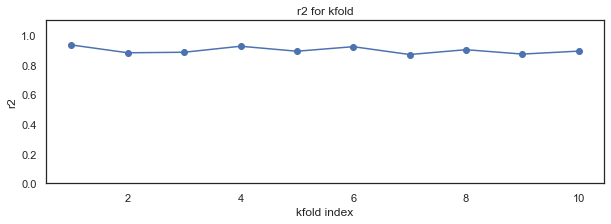

r-squared k-fold cross validation:                 .................0.9
r-squared std:                                     ................0.02


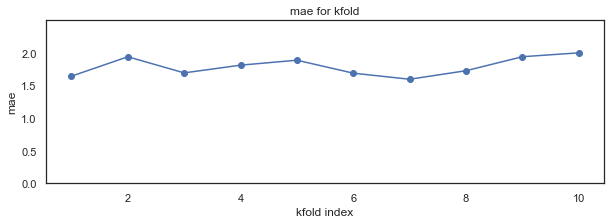



mean absolute error k-fold cross validation:       ................1.79
mean absolute error std:                           ................0.14


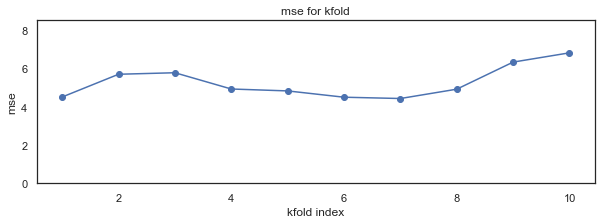



mean squared error k-fold cross validation:        ................5.26
mean squared error std:                            ................0.83


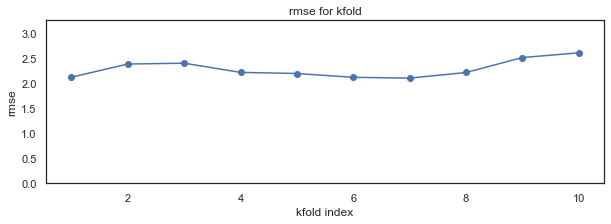



root mean squared error k-fold cross validation:   ................2.29
root mean squared error std:                       ................0.18




In [21]:
# K-fold cross validation regression evaluation metrics for train data
regression_cross_val(regressor = LinearRegression(), X_train = X_train, y_train = y_train, cv = 10)

The model performance appears to deliver strong and consistent results on the train data. 

Above are the k-fold cross validation results.

In [23]:
# Convert data frames to numpy arrays
X_train = X_train_df.iloc[:,:].values
y_train = y_train_df.iloc[:,:].values
y_train = y_train.reshape((-1,))

X_test = X_test_df.iloc[:,:].values
y_test = y_test_df.iloc[:,:].values
y_test = y_test.reshape((-1,))

# Fit and train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict with X_train data
y_pred_train = regressor.predict(X_train)
# Create data frame with predicted results for train data
y_pred_train_df = pd.DataFrame(y_pred_train, columns = ['predictions_train']).reset_index()

# Create a single data frame with all prediction and actual y data for train data
y_train_df = pd.DataFrame(y_train, columns = ['aboveMeanAdjWins']).reset_index()
pred_train_df = pd.merge(y_pred_train_df, y_train_df, on = 'index')
y_pred_train_df = y_pred_train_df.drop(['index'], axis = 1, errors = 'ignore')
y_train_df = y_train_df.drop(['index'], axis = 1, errors = 'ignore')
pred_train_df['residuals_train'] = pred_train_df['predictions_train'] - pred_train_df['aboveMeanAdjWins']

print('\n')
pred_train_df.info()
display(pred_train_df.head())

print('\n')
Xlabels = X_train_df.columns
stat.summary(regressor, X_train, y_train, Xlabels)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 708
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              709 non-null    int64  
 1   predictions_train  709 non-null    float64
 2   aboveMeanAdjWins   709 non-null    float64
 3   residuals_train    709 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 27.7 KB


,index,predictions_train,aboveMeanAdjWins,residuals_train
0,0,-3.276630,-1.600000,-1.676630
1,1,3.856807,4.071429,-0.214622
2,2,-0.074430,-3.764706,3.690276
3,3,4.453941,3.089286,1.364655
4,4,11.597250,16.153846,-4.556596




Residuals:
    Min     1Q  Median     3Q   Max
-8.2963 -1.471 -0.0142 1.4211 7.392


Coefficients:
                             Estimate  Std. Error  t value  p value
_intercept                  -0.942519    0.137210  -6.8692      0.0
shootingPctg                 6.112089    0.105344  58.0204      0.0
savePctg                     6.018233    0.110446  54.4905      0.0
savesPerGame                -3.202418    0.088039 -36.3751      0.0
failedShotsPerGame           2.728279    0.088620  30.7862      0.0
winScoreFirstGreater61_high  1.358091    0.202241   6.7152      0.0
---
R-squared:  0.90303,    Adjusted R-squared:  0.90234
F-statistic: 1309.33 on 5 features


The above is a data frame focusing on the train model results.

The model shows strong results on the train data.  

Additionally, the adj-r2 is virtually similar to r2 (0.001 difference) showing the impact of the multiple features included in the model.

Further, the regression model is determined to be significant at p < 0.05 (**Prob (F-statistic: 1309.33): 0.00**). This reveals that the regression model explains the the adjusted wins over the mean adjusted wins target variable well and not by random chance.

All predictors' coefficients are significant at p < 0.05 (removed penaltyKillPercentage and powerPlayPercentage) and have a significant impact on the predicted adjusted wins over the mean adjusted wins target variable. The impact of the predictors are as follows:

1) **shootingPctg** - Intuitively, as the percent of shots leading to goals increases, the aboveMeanAdjWins also increases. This outcome can be perceived as, among many other factors, as offensive efficiency, strategy efficiency, more offensive skill, physically in shape team, creating impactful shot attempts, etc. <br><br>

2) **savePctg** - Intuitively, as save percentage increases, the aboveMeanAdjWins also increases. This outcome can be perceived as goaltending skill, efficient defensive strategy, defensive skill, physically in shape team, forcing bad shots attempts, etc. <br><br>

3) **savesPerGame** - As saves per game increase, the aboveMeanAdjWins decreases. This outcome can be perceived as more work the goaltender outputs, more time players spend defending, less time in the offensive zone, lacking offensive and defensive strategy, lack of offensive and defensive skill, the pace being set by the opposing team, physically out of shape team, etc. <br><br>

4) **failedShotsPerGame** - As shot attempts increase, the aboveMeanAdjWins also increases. This outcome can be perceived as spending more time in the offensive zone, less time in the defensive zone, offensive and defensive skill, setting the pace of the game, putting a heavy workload on the opposing team, better offensive and defensive strategy, physically in shape team, etc. <br><br>

5) **winScoreFirstGreater61_high** - As teams win a higher percentage (> 61%) of the games they score first in reference to winning a lower percentage (<= 61%) of the games they score first, the aboveMeanAdjWins increases. This outcome can be perceived as simply winning more games, good strategy as the game progresses, physically in of shape team, more defensive skill, etc. <br><br>

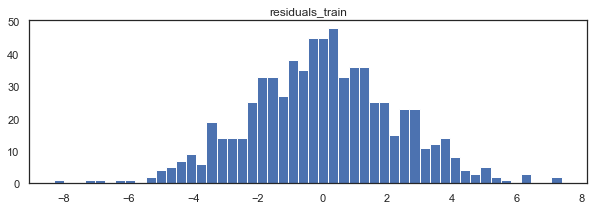


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_train,709.0,-2.254896e-17,2.277137,-8.296252,-1.470983,-0.014249,1.421126,7.392024



normality test:

statistic: 0.33
pvalue: 2.25



In [24]:
# residuals_train distribution
wins = pred_train_df.copy()
wins = pred_train_df[['residuals_train']]
num_univariate_histogram(df = wins, length = 3, width = 10, rows = 1, col = 1, font = 1, kind = 2)
print('\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + str(round(normaltest(wins.residuals_train.values)[1], 2)) +
      '\n' + 'pvalue: ' + str(round(normaltest(wins.residuals_train.values)[0],2)) + '\n')

The residuals are normally distributed as shown by the large pvalue > 0.05. 

The residuals' mean is 0 indicating that the errors are close to 0.

The distribution also displays that there are outliers on the left tail staring from roughly -6 and below and on the right tail being  roughly 6 and above.

The outliers show the models under and over prediction of aboveMeanAdjWins.

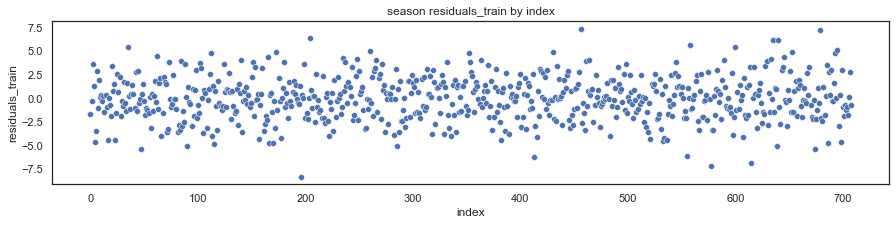

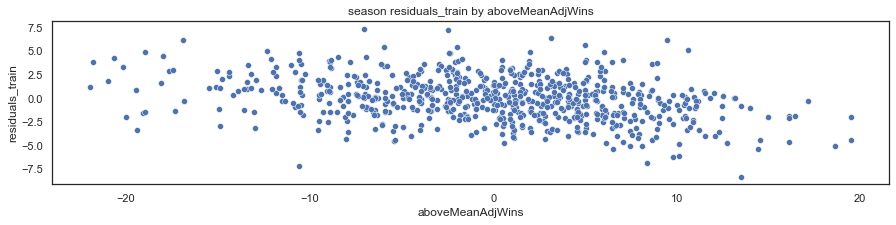

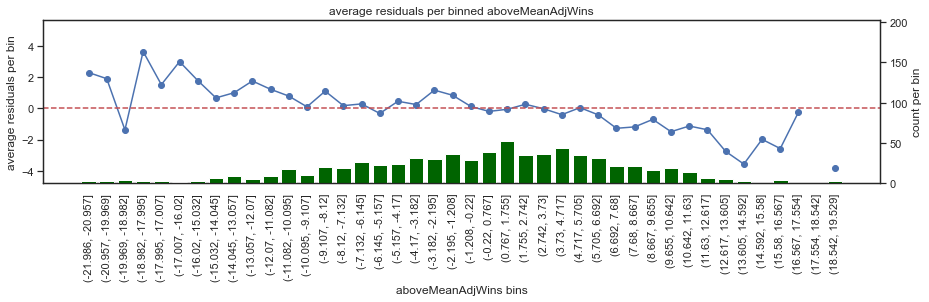

In [29]:
# residuals_train by index scatter plot
target_univariate_scatter(df = pred_train_df, x = 'index', y = 'residuals_train', length = 3, width = 15, font = 1)
# residuals_train by aboveMeanAdjWins scatter plot
target_univariate_scatter(df = pred_train_df, x = 'aboveMeanAdjWins', y = 'residuals_train', length = 3, width = 15, 
                          font = 1)
# Residual means and counts plot
residual_means_counts_plot(df = pred_train_df, X = 'aboveMeanAdjWins', res = 'residuals_train', 
                            ymin1 = -1, ymax1 = 2, ymin2 = 0, ymax2 = 150)

The residuals appear to be randomly distributed as show by the aboveMeanAdjWins by index scatter plot above.

The model also appears to over predict where the aboveMeanAdjWins are low and under predict where the aboveMeanAdjWins are high.

The over and under predictions at the tail ends of aboveMeanAdjWins target variable distribution (outliers). The low sample representation may be the reason for larger errors. 

Over all the residuals are not overwhelmingly high.

**Note** - the empty space in the line plot are NA values.

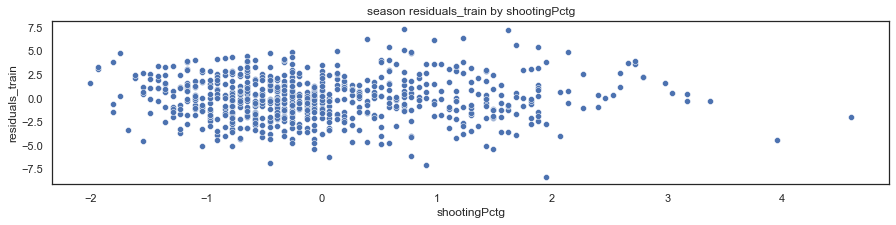

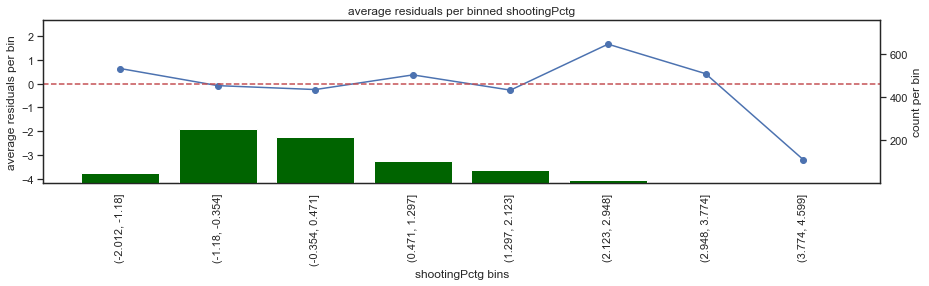

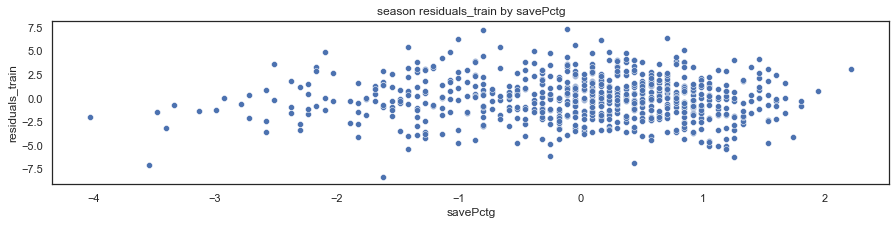

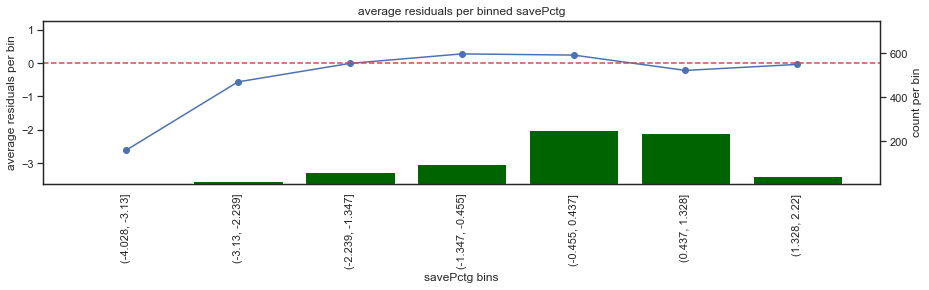

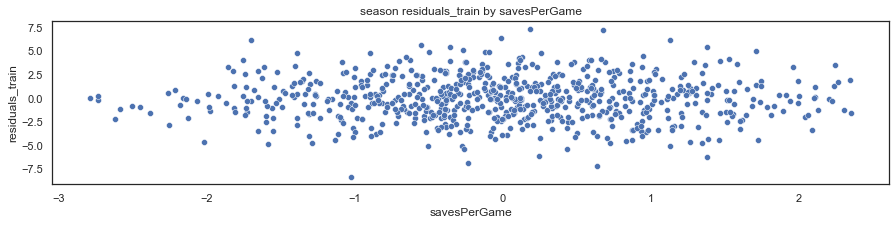

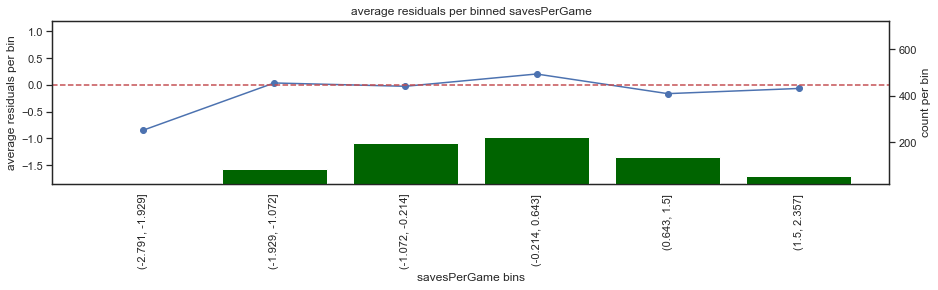

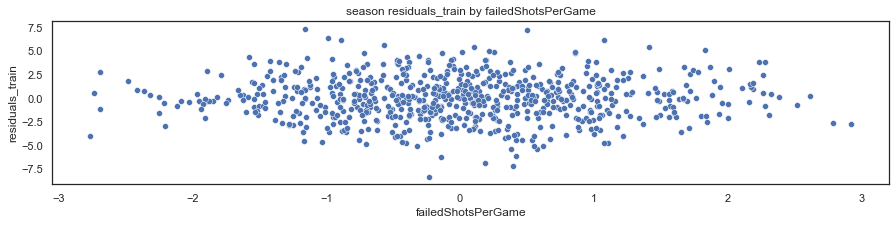

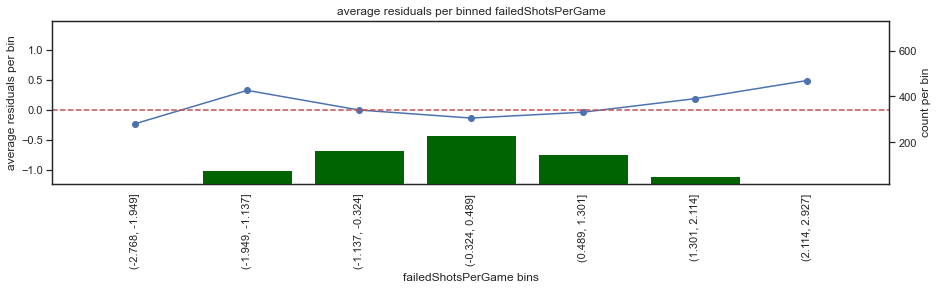

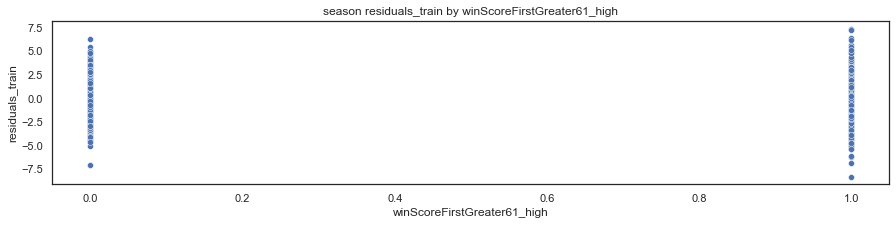

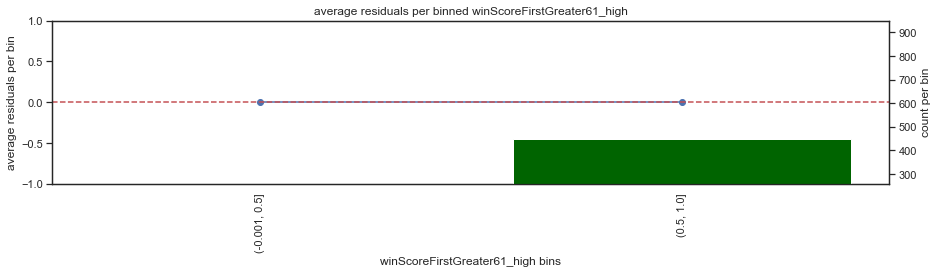

In [23]:
# residuals_train by all predictor variables plots
res_train_df = pd.concat([X_train_df, pred_train_df], axis = 1)
X_train_col = X_train_df.columns

for X in X_train_col:
    target_univariate_scatter(df = res_train_df, x = X, y = 'residuals_train', length = 3, width = 15, font = 1)
    residual_means_counts_plot(df = res_train_df, X = X, res = 'residuals_train', 
                               ymin1 = -1, ymax1 = 1, ymin2 = 0, ymax2 = 500)

Again there appears to be some variance of the residual errors per feature outside of winScoreFirst61_high.
Some festures display more variance than others. 

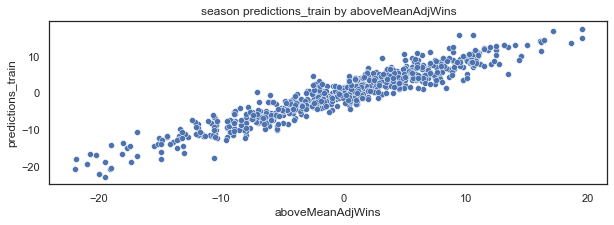

In [30]:
# Predicted aboveMeanAdjWins results by actual aboveMeanAdjWins for train data
target_univariate_scatter(df = pred_train_df, x = 'aboveMeanAdjWins', y = 'predictions_train',
                          length = 3, width = 10, font = 1)

The model predictions are compared with the target variable (aboveMeanAdjWins) and display good results due to the tight line, showing that the errors are relatively low. 

As aboveMeanAdjWins increases or decreases, the predictions follow.

#### Model Testing, Evaluation, and Interpretation  

In [31]:
# Predict with X_test
y_pred_test = regressor.predict(X_test)
# Create data frame of predicted results
y_pred_test_df = pd.DataFrame(y_pred_test, columns = ['predictions_test']).reset_index()

# Create a single data frame with all prediction and actual y data for test data
y_test_df = pd.DataFrame(y_test, columns = ['aboveMeanAdjWins']).reset_index()
pred_test_df = pd.merge(y_pred_test_df, y_test_df, on = 'index')
y_pred_test_df = y_pred_test_df.drop(['index'], axis = 1, errors = 'ignore')
y_test_df = y_test_df.drop(['index'], axis = 1, errors = 'ignore')
pred_test_df['residuals_test'] = pred_test_df['predictions_test'] - pred_test_df['aboveMeanAdjWins']

print('\n')
pred_test_df.info()
pred_test_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             178 non-null    int64  
 1   predictions_test  178 non-null    float64
 2   aboveMeanAdjWins  178 non-null    float64
 3   residuals_test    178 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 7.0 KB


,index,predictions_test,aboveMeanAdjWins,residuals_test
0,0,1.431646,2.153846,-0.722200
1,1,1.125550,3.827586,-2.702036
2,2,-12.984844,-15.696429,2.711585
3,3,-9.645879,-13.413793,3.767914
4,4,9.238981,5.086207,4.152774


The above is a data frame focusing on the test model results.

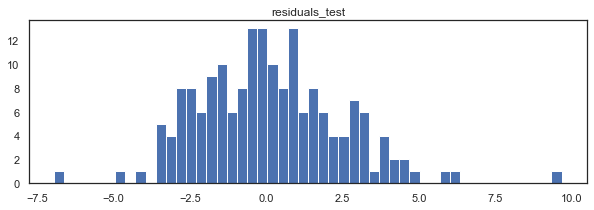


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_test,178.0,0.107097,2.310177,-6.935627,-1.544365,-0.090941,1.548588,9.67279



normality test:

statistic: 0.0
pvalue: 12.68



In [32]:
# residuals_test distribution
wins = pred_test_df[['residuals_test']]
num_univariate_histogram(df = wins, length = 3, width = 10, rows = 1, col = 1, font = 1, kind = 2)
print('\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + str(round(normaltest(wins.residuals_test.values)[1], 2)) +
      '\n' + 'pvalue: ' + str(round(normaltest(wins.residuals_test.values)[0],2)) + '\n')

The residuals are normally distributed and the mean is 0 indicating that the errors are close to 0.

The distribution also displays that there are a outliers on the left tail being roughly -5 and below and on the right tail being oguhly 6 and above.

The outliers show the models under and over prediction of aboveMeanAdjWins.

This is in-line with the training results.

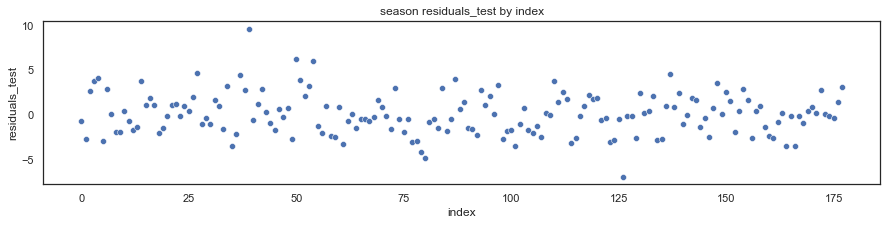

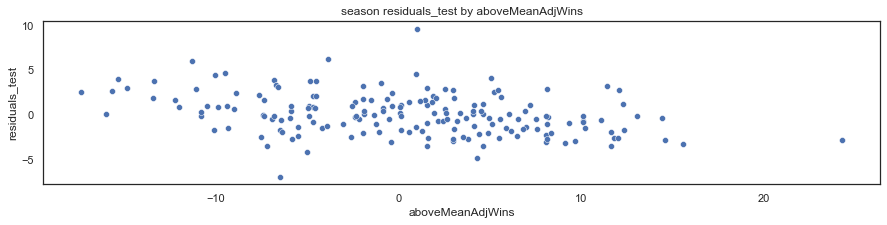

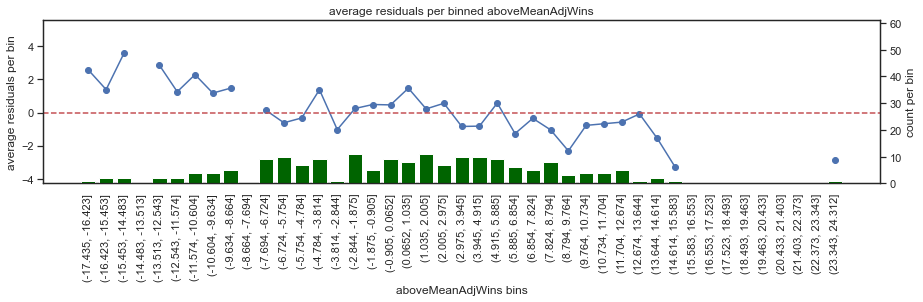

In [33]:
# residuals_test by index scatter plot
target_univariate_scatter(df = pred_test_df, x = 'index', y = 'residuals_test', length = 3, width = 15, font = 1)
# residuals_test by aboveMeanAdjWins scatter plot
target_univariate_scatter(df = pred_test_df, x = 'aboveMeanAdjWins', y = 'residuals_test', 
                          length = 3, width = 15, font = 1)
# Residual means and counts plot
residual_means_counts_plot(df = pred_test_df, X = 'aboveMeanAdjWins', res = 'residuals_test',
                          ymin1 = -1, ymax1 = 2, ymin2 = 0, ymax2 = 50)

The residuals appear to be similar but as expected, not as consistant as the train data.

Over all the residuals are not overwhelmingly high.

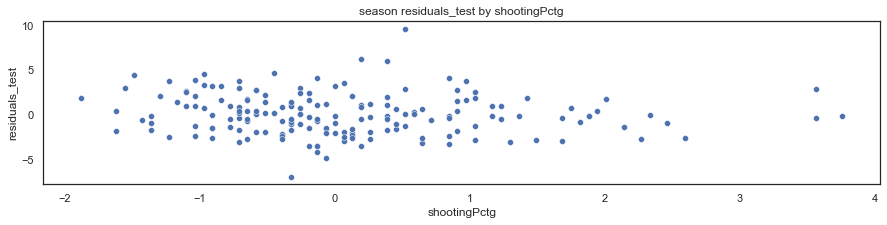

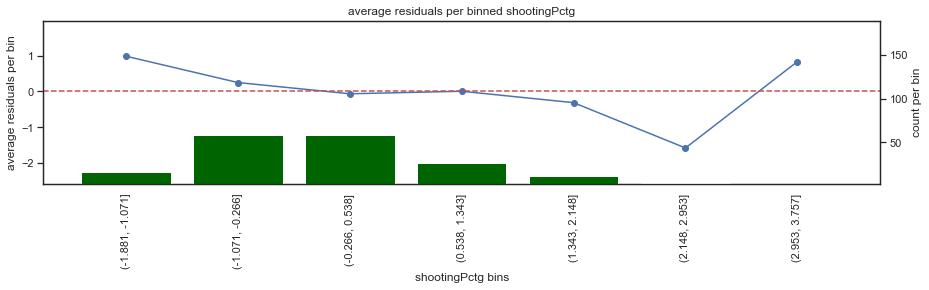

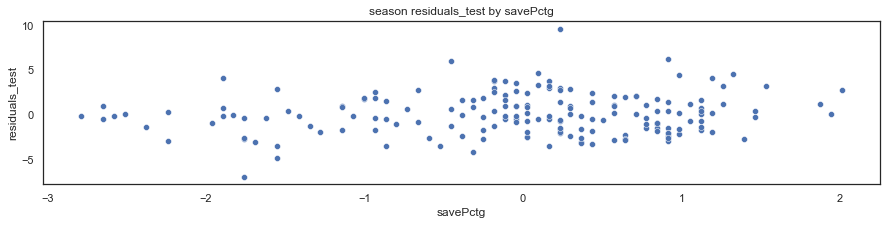

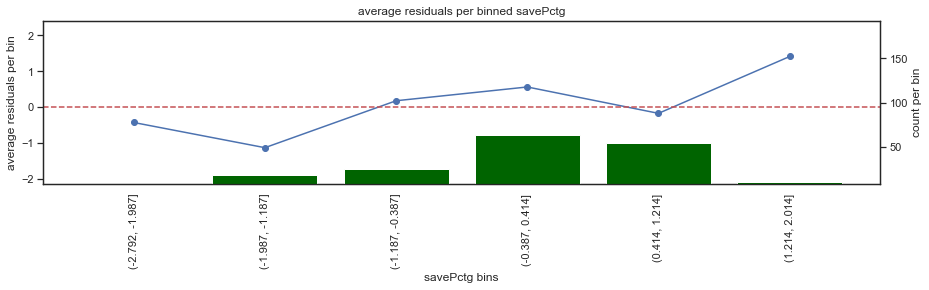

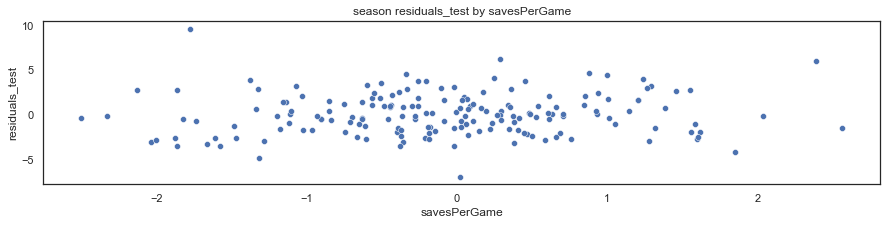

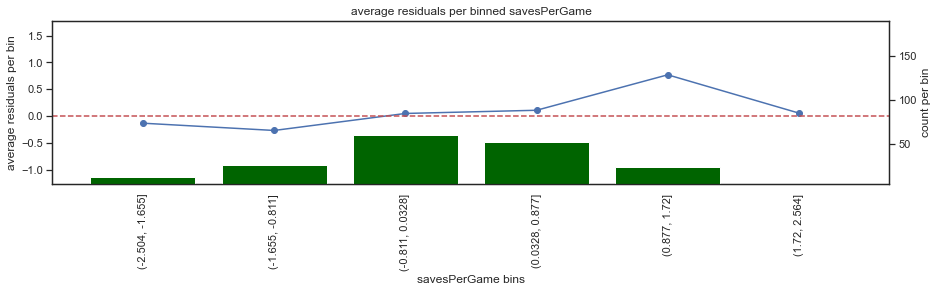

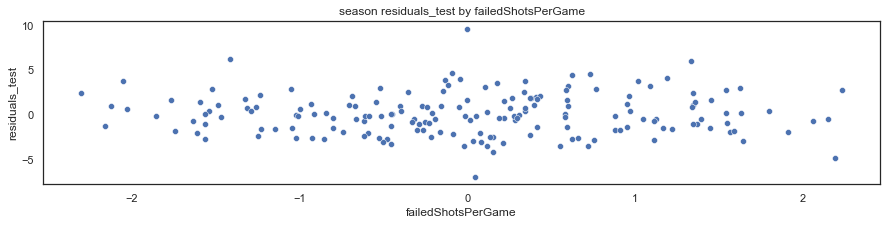

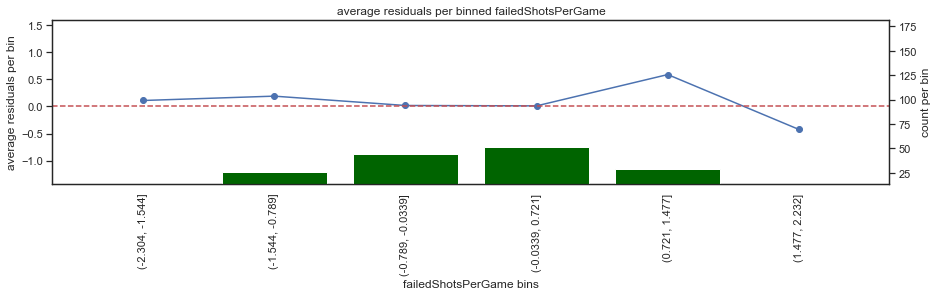

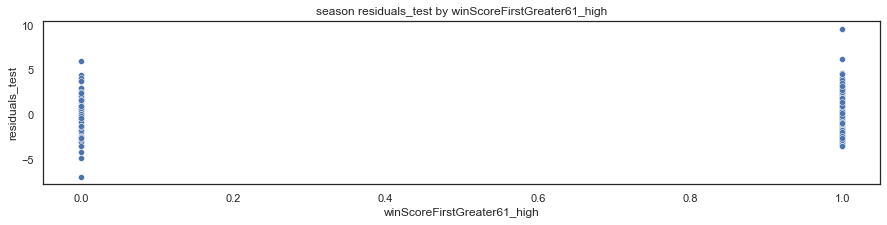

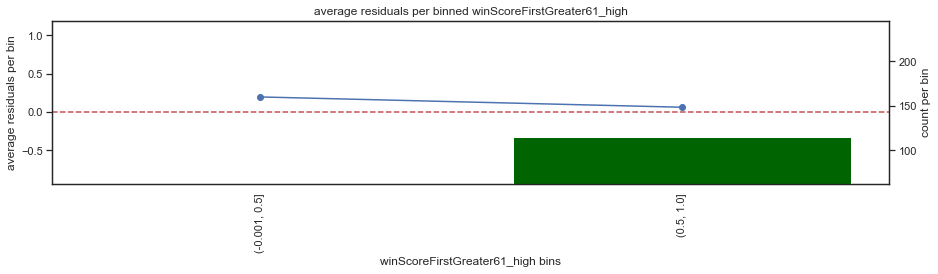

In [27]:
# residuals_test by all predictor variables plots
res_test_df = pd.concat([X_test_df, pred_test_df], axis = 1)
X_test_col = X_test_df.columns

for X in X_test_col:
    target_univariate_scatter(df = res_test_df, x = X, y = 'residuals_test', length = 3, width = 15, font = 1)
    residual_means_counts_plot(df = res_test_df, X = X, res = 'residuals_test',
                              ymin1 = -1, ymax1 = 1, ymin2 = 0, ymax2 = 130)

Again as expected, the variance of the residual errors per feature appear to be slightly greater than the train data.

Over all the residuals are not overwhelmingly high.

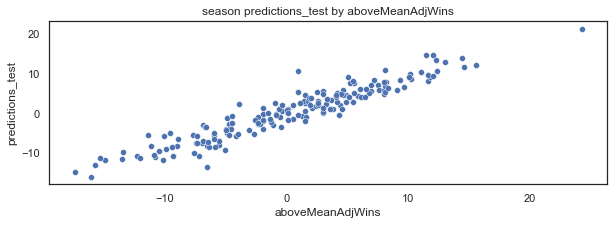

In [20]:
# Regression result metrics and summary for train data
target_univariate_scatter(df = pred_test_df, x = 'aboveMeanAdjWins', y = 'predictions_test', 
                          length = 3, width = 10, font = 1)

The predicted values by abovMeanAdjWins line appears to be relatively tight but slightly less than th etrain data.

In [21]:
# Regression evaluation metrics and summary for test data
regression_test_metrics(y = y_test_df, y_pred = y_pred_test_df)


model metrics:

r-squared:                          .................0.9
mean absolute error:                ................1.79
mean squared error:                 ................5.32
root Mean squared error:            ................2.31


The model shows strong results on the test data. 

The r2 remains the same as the training evaluation results. The MAE, MSE and RMSE have increased slightly (evaluation metrics dropped in accuracy), however, are similar to the training results.

### Model Finalization

#### Model Finalizing, Evaluation, and Interpretation  

In [39]:
# Finalize model with full rescaled data set
# Get X values
X = nhl_df.copy()
X = X[X_train_df.columns]

# Scale X values (converts X values to numpy 2D array)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Get y values
y = nhl_df.copy()
y = y[y_train_df.columns]

# Convert y values to numpy 1D array
y= y.iloc[:,:].values
y = y.reshape((-1,))

# Fit regressor
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

The above block of code finalizes that model by training on all data available (train and test data).

In [40]:
# Save the model
dump(regressor, open('NHL_Season_Wins_Linear_Regression_Model.pkl', 'wb'))

Save the regression model.

In [41]:
# load the model
regressor = load(open('NHL_Season_Wins_Linear_Regression_Model.pkl', 'rb'))

Load the regression model.

Residuals:
    Min      1Q  Median     3Q    Max
-8.1564 -1.5343 -0.0408 1.4154 9.7041


Coefficients:
                             Estimate  Std. Error  t value  p value
_intercept                   0.000000    0.076573   0.0000      1.0
shootingPctg                 6.149515    0.096089  63.9982      0.0
savePctg                     5.986662    0.103245  57.9853      0.0
savesPerGame                -3.194651    0.079287 -40.2923      0.0
failedShotsPerGame           2.732544    0.080546  33.9253      0.0
winScoreFirstGreater61_high  0.682706    0.091221   7.4841      0.0
---
R-squared:  0.90273,    Adjusted R-squared:  0.90218
F-statistic: 1635.31 on 5 features


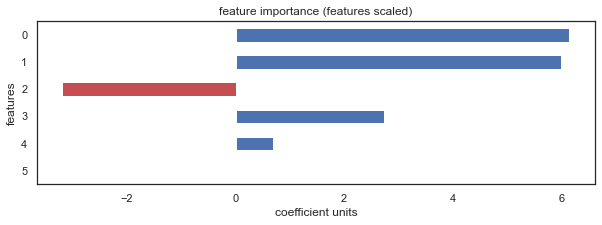

,coef,positive
,,
shootingPctg,6.149515,True
savePctg,5.986662,True
savesPerGame,-3.194651,False
failedShotsPerGame,2.732544,True
winScoreFirstGreater61_high,0.682706,True
intercept,0.0,True


In [42]:
# Regressor Summary
Xlabels = X_train_df.columns
stat.summary(regressor, X, y, Xlabels)

# Feature improtance bar chart
regression_feature_importance(model = regressor, X_cols = X_train_df, font = 1, length = 3, width = 10)

Above we can see which features have the largest impact on aboveMeanAdjWins per unit increase on a scaled basis.

NHL Organizations can use this information to prioritize when strategizing or building their teams.